# 北尾早霧・砂川武貴・山田知明『定量的マクロ経済学と数値計算』日本評論社
## 第2章：2期間モデルと数値計算の概観

## 2.5 一階条件を使う：求根アルゴリズム
### 2.5.1 非線形方程式のゼロ点を探す

### パラメータの設定はこれまでとまったく同じ

In [3]:
class Models:
    def __init__(self,β:float,γ:float,rent:float,nw:int,w_max:float,w_min:float,grid_w:"np.ndarray[np.float64]"):
        # パラメータ
        self.β = β # 割引因子
        self.γ = γ # 相対的危険回避度

        # 要素価格
        self.rent = rent # 純利子率

        # グリッド
        self.nw = nw # 所得グリッドの数
        self.w_max = w_max # 所得グリッドの最大値
        self.w_min = w_min # 所得グリッドの最小値 
        self.grid_w = grid_w # 所得グリッド

In [4]:
def Calibration():
    # パラメータはここで設定をする
    β = 0.985**30
    γ = 2.0
    rent = 1.025**30 - 1.0
    nw = 10
    w_max = 1.0
    w_min = 0.1

    grid_w = np.linspace(w_min,w_max,nw)

    return Models(β, γ, rent, nw, w_max, w_min, grid_w)

## 経済学でよく使う関数を設定しておく

In [5]:
def mu_CRRA(cons,γ):
    return cons**(-γ)

---

In [6]:
# 使う関数を呼び出す
import numpy as np # 配列を扱うためのパッケージ
import matplotlib.pyplot as plt # プロットを行うためのパッケージ
import japanize_matplotlib # プロットで日本語を使うためのパッケージ
from scipy import optimize # Python上の Optimization Tool
import time # 計測時間をはかるためのパッケージ

In [7]:
# パラメータを設定
params = Calibration()

---

## ゼロ点を探す関数を作成
* 残差関数(residual function)
* テキストの(2.8)式

In [8]:
def resid_two_period(a,w_val,params):
    """
    2期間モデルの1階条件の残差を求める

    # インプット
    `a`: 貯蓄水準
    `w_val`: 所得水準
    `params`: パラメータを含む構造体

    # アウトプット
    残差
    """

    # オイラー方程式の左辺：若年期の限界効用
    if w_val - a > 0.0:
        mu1 = mu_CRRA(w_val-a, params.γ)
    else:
        mu1 = 10000.0

    # 老年期の限界効用
    mu2 = mu_CRRA((1.0 + params.rent)*a, params.γ)

    # 残差(residual)
    return params.β*(1.0 + params.rent)*(mu2/mu1) - 1.0

# 実際にゼロ点を探す

In [9]:
# 空っぽの変数を用意：policy functionの器
a_nl = np.zeros(params.nw)

In [16]:
# 実際に各w_{i}のもとで、残差関数がゼロになるようなaを探す
for (w_ind,w_val) in enumerate(params.grid_w):

    # 1変数のfunctionにする
    resid_two_period1 = lambda a: resid_two_period(a, w_val, params)

    # 0.01はゼロ点を探す際の初期値
    res = optimize.fsolve(resid_two_period1,x0=0.01)
    a_nl[w_ind] = res[0]

print(a_nl)

[0.03550089 0.07100178 0.10650266 0.14200355 0.17750444 0.21300533
 0.24850621 0.2840071  0.31950799 0.35500888]


### ⬆のプロセスと一つの関数にまとめておく

In [17]:
def Root_find(params):
    """
    ゼロ点探索によって2期間モデルを解く

    # インプット
    `m::Models`:パラメータを含む構造体

    # アウトプット
    `a_nl::Vector`:政策関数
    """

    a_nl = np.zeros(params.nw)

    for (w_ind,w_val) in enumerate(params.grid_w):

        resid_two_period1 = lambda a: resid_two_period(a, w_val, params)
        res = optimize.fsolve(resid_two_period1,x0=0.01)
        a_nl[w_ind] = res[0]
    
    return a_nl

In [18]:
# 関数の実行

start = time.time() # 実行時間の計測開始
a_nl = Root_find(params) 
end = time.time() # 実行時間の計測終了

print(f"{end-start:.6f} seconds")
print(a_nl)

0.002997 seconds
[0.03550089 0.07100178 0.10650266 0.14200355 0.17750444 0.21300533
 0.24850621 0.2840071  0.31950799 0.35500888]


---

## 結果を出力

In [19]:
# 解析解
# テキストの(2.4)式
coef1 = (params.β*(1.0+params.rent))**(-1.0/params.γ)
coef2 = 1.0/(1.0+coef1*(1.0+params.rent))
a_cfs = coef2*params.grid_w

---

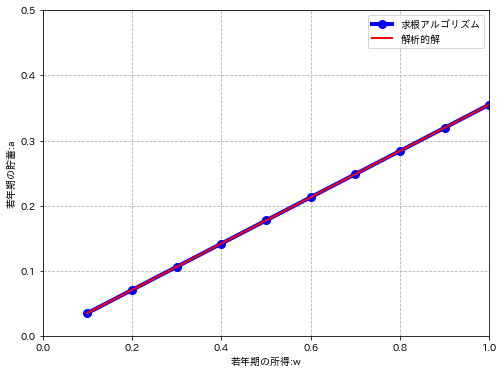

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.grid_w,a_nl,c="b",marker="o",lw=4,ms=8,label="求根アルゴリズム")
ax.plot(params.grid_w,a_cfs,c="r",lw=2,label="解析的解")
ax.set(xlabel="若年期の所得:w",ylabel="若年期の貯蓄:a",xlim=(0,1.0),ylim=(0,0.5))
ax.legend(loc="upper right")
ax.grid(ls="--")
plt.show()

---

### 残差をプロットしてみる：図2.3

In [21]:
def resid_ex(params):
    """
    本文中の残差についての図を書くための関数
    """

    na = 40
    a_max = 1.0
    a_min = 0.025
    grid_a = np.linspace(a_min, a_max, na)

    resid = np.zeros((na,3))
    grid_zero = np.zeros(na)

    wlist = [0.5, 0.8, 1.0]

    for (w_ind,w_val) in enumerate(wlist):

        resid_two_period1 = lambda a: resid_two_period(a, w_val, params)
        for j in range(na):
            resid[j, w_ind] = resid_two_period1(grid_a[j])
        
    return resid, grid_zero

In [22]:
resid, grid_zero = resid_ex(params)

In [23]:
na = 40
a_max = 1.0
a_min = 0.025
grid_a = np.linspace(a_min, a_max, na)

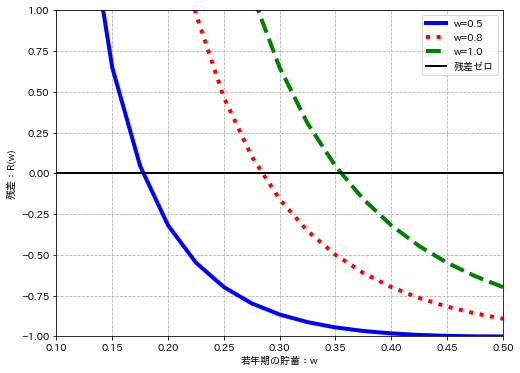

In [24]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(grid_a,resid[:,0],c="b",ls="-",lw=4,label="w=0.5")
ax.plot(grid_a,resid[:,1],c="r", ls=":",lw=4,label="w=0.8")
ax.plot(grid_a,resid[:,2],c="g",ls="--",lw=4,label="w=1.0")
ax.plot(grid_a,grid_zero,c="k",lw=2,label="残差ゼロ")
ax.set(xlabel="若年期の貯蓄：w",ylabel="残差：R(w)",xlim=(0.1,0.5),ylim=(-1.0,1.0))
ax.legend()
ax.grid(ls="--")
plt.show()

---

## エクササイズ
* 最適化を用いたアルゴリズムから導出した政策関数の精度を確認してみよう。